In [1]:
import numpy as np
import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time as clock
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import trange, tqdm
from diffusion_equation import compute_solution
from time import time
# from tqdm import trange
import pandas as pd
from sklearn.metrics import r2_score
import torch
from torch import nn
from torchvision import models

In [2]:
DEVICE = 'mps'

In [3]:
def flat_the_gradient_from_loss(model, loss):
    model.zero_grad()
    loss.backward(retain_graph=True)
    grads = []
    for p in model.parameters():
        if p.grad is not None:
            grads.append(p.grad.detach().cpu().numpy().reshape(-1))
    grad_flat = np.concatenate(grads)
    return grad_flat

def orthogonalize(v1, v2):
    dot = np.dot(v1, v2)
    proj = dot / (np.dot(v1, v1) + 1e-6) * v1
    return v2 - proj

def compute_weights_grad_orthogonal_autograd(model, loss_ic, loss_pde, loss_data, kappa=5.0, eps=1e-6):
    grad_ic   = flat_the_gradient_from_loss(model, loss_ic)
    grad_pde  = flat_the_gradient_from_loss(model, loss_pde)
    grad_data = flat_the_gradient_from_loss(model, loss_data)

    grad_pde_orth = orthogonalize(grad_ic, grad_pde)
    grad_data_orth = orthogonalize(grad_ic, grad_data)
    grad_data_orth = orthogonalize(grad_pde_orth, grad_data_orth)

    lv_ic = loss_ic.detach().cpu().numpy()
    lv_pde = loss_pde.detach().cpu().numpy()
    lv_data = loss_data.detach().cpu().numpy()

    w_ic = 1.0
    w_pde = np.exp(-kappa * lv_ic) * np.linalg.norm(grad_pde_orth)
    w_data = np.exp(-kappa * max(lv_ic, lv_pde)) * np.linalg.norm(grad_data_orth)
    w_sum = w_ic + w_pde + w_data + eps
    w_ic /= w_sum
    w_pde /= w_sum
    w_data /= w_sum


    # model.zero_grad()

    return w_ic, w_pde, w_data


# Getting data from simulator

In [4]:
# configuration of simulator
# and parametrs of reservouir
niter = 100
perm = np.load('perm_3sigma.npy')
nx0, nx1 = perm.shape
nx2 = 1
perm = np.reshape(perm, (nx0, nx1, nx2))
poro = 0.1 + np.zeros((nx0, nx1, nx2))

dx0 = 1.0 / nx0
dx1 = 1.0 / nx1
dx2 = 1.0 / nx2

pwat = 2.0
poil = 4.0
vr = 0.3
kwat = 1.0
koil = 0.3

pmin = 0.0
pmax = 1.0

t_final = 3.0
dt = t_final / niter

# Read from file

In [5]:
# sim_data: pres, swat, soil
sim_data = np.load("data-100-new-3sigma/sim_100.npy").astype(np.float32)#[sim_nidexes]

pwat_list = np.load("data-100-new-3sigma/pwat_100.npy").astype(np.float32)
poil_list = np.load("data-100-new-3sigma/poil_100.npy").astype(np.float32)
kwat_list = np.load("data-100-new-3sigma/kwat_100.npy").astype(np.float32)
koil_list = np.load("data-100-new-3sigma/koil_100.npy").astype(np.float32)

In [6]:
niter = 100
nx, ny = 64, 64
t_final = 3.0
dt = t_final / niter
dx, dy = 1 / nx, 1 / ny

indexes_high = np.argwhere(sim_data[:, :, :, :, :, 1] > 0)
# indexes_low = np.argwhere((sim_data[:, :, :, :, :, 1] > 0) & (sim_data[:, :, :, :, :, 1] < 0.1))
# indexes_low = indexes_low[np.random.randint(0, indexes_low.shape[0], indexes_high.shape[0])]

indexes = indexes_high#np.vstack([indexes_low, indexes_high])
simulation_data = np.zeros((indexes.shape[0], 3))
for i, row in enumerate(indexes):
    simulation_data[i] = sim_data[row[0], row[1], row[2], row[3], row[4], :3]

x_list = indexes[:, 0] * dx
y_list = indexes[:, 1] * dy
t_list = indexes[:, 3] * dt

pwat_rand = pwat_list[indexes[:, -1]]
poil_rand = poil_list[indexes[:, -1]]
kwat_rand = kwat_list[indexes[:, -1]]
koil_rand = koil_list[indexes[:, -1]]

In [29]:
rand_indexes_2000 = np.random.randint(0, simulation_data.shape[0], 2000)
rand_indexes_1000 = np.random.randint(0, simulation_data.shape[0], 1000)
rand_indexes_500 = np.random.randint(0, simulation_data.shape[0], 500)
rand_indexes_250 = np.random.randint(0, simulation_data.shape[0], 250)

np.save('train-indexes-3sigma-2000.npy', rand_indexes_2000)
np.save('train-indexes-3sigma-1000.npy', rand_indexes_1000)
np.save('train-indexes-3sigma-500.npy', rand_indexes_500)
np.save('train-indexes-3sigma-250.npy', rand_indexes_250)


rand_indexes_2000 = np.load('train-indexes-3sigma-2000.npy')
rand_indexes_1000 = np.load('train-indexes-3sigma-1000.npy')
rand_indexes_500 = np.load('train-indexes-3sigma-500.npy')
rand_indexes_250 = np.load('train-indexes-3sigma-250.npy')

In [30]:
rand_indexes = rand_indexes_500

simulation_data_train = torch.tensor(simulation_data.astype(np.float32))[rand_indexes].requires_grad_(True)

x = torch.tensor(x_list.astype(np.float32))[rand_indexes].requires_grad_(True)
y = torch.tensor(y_list.astype(np.float32))[rand_indexes].requires_grad_(True)
t = torch.tensor(t_list.astype(np.float32))[rand_indexes].requires_grad_(True)


pwat = torch.tensor(pwat_rand.astype(np.float32))[rand_indexes]
poil = torch.tensor(poil_rand.astype(np.float32))[rand_indexes]
kwat = torch.tensor(kwat_rand.astype(np.float32))[rand_indexes]
koil = torch.tensor(koil_rand.astype(np.float32))[rand_indexes]

points = torch.stack((t, x, y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

In [31]:
pd.DataFrame(data=simulation_data_train.cpu().detach().numpy(), columns=['pres', 'swat', 'soil']).describe()

,pres,swat,soil
count,500.000000,5.000000e+02,500.000000
mean,0.422735,4.323126e-02,0.956769
std,0.304132,1.255933e-01,0.125593
min,0.001020,1.829535e-41,0.375453
25%,0.185085,1.091373e-36,1.000000
50%,0.327061,4.228206e-33,1.000000
75%,0.714768,2.240858e-29,1.000000
max,0.995664,6.245468e-01,1.000000


In [32]:
pres0_x1_points = torch.stack(
    (t, torch.zeros_like(x), y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

pres1_x1_points = torch.stack(
    (t, torch.ones_like(x), y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

swat0_x1_points = torch.stack(
    (torch.zeros_like(t), x, y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

soil0_x1_points = torch.stack(
    (torch.zeros_like(t), x, y, pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

u0_x2_points = torch.stack(
    (t, x, torch.zeros_like(y), pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

u1_x2_points = torch.stack(
    (t, x, torch.ones_like(y), pwat, poil, kwat, koil), -1).requires_grad_(True).to(DEVICE)

# Model configuration

In [44]:
class pinn_model(nn.Module):
    def __init__(self, input_layer=7, hidden_layer=128, number_layers=4, output_layer=7):
        super(pinn_model, self).__init__()
        
        # Simplified model with fewer layers and smaller hidden layer size
        self.hidden_layer = hidden_layer
        
        # Initial layer
        self.fcs = nn.Sequential(
            nn.Linear(input_layer, hidden_layer),
            nn.ReLU()
        )
        
        # Reduced number of hidden layers
        self.fch = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_layer, hidden_layer),
                nn.ReLU()
            )
            for _ in range(number_layers - 1)
        ])
        
        self.fc_out = nn.Linear(hidden_layer, output_layer)
        
    #     self._initialize_weights()
        
    # def _initialize_weights(self):
    #     for layer in self.modules():
    #         if isinstance(layer, nn.Linear):
    #             nn.init.xavier_uniform_(layer.weight)  # Xavier for better weight scaling
    #             if layer.bias is not None:
    #                 nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        """
        Forward pass through the network
        
        Args:
            x: Input tensor of shape (batch_size, input_layer)
        
        Returns:
            x - vector (pres
                        soil
                        swat
                        uoil_x,  
                        uoil_y,
                        uwat_x,  
                        uwat_y)
        """
        # Pass through the first layer
        x = self.fcs(x)
        
        # Pass through hidden layers (no skip connections for simplicity)
        for layer in self.fch:
            x = layer(x)
        
        # Final output layer (using Softplus to enforce positive output)
        x = self.fc_out(x)
        u = x[:, -4:]
        out = x[:, :-4]
        out = F.softplus(out)  # Ensuring the output is strictly positive
        return torch.cat([out, u], -1)

# Differentiail equations, Loss function difinition

$$k_{water} = 1, k_{oil} = 0.3$$
$$x = (x_1, x_2)$$
$$ \phi(x) = 0.1 (poro)\\
k(x) = 1 (perm)$$

#### System of equation:

\begin{equation}
    \begin{cases}
        r_1(t, x) = 0.1 \frac{\partial s_{\text{water}}(t, x)}{\partial t} + div(u_{water}) = 0 \\
        r_2(t, x) = 0.1 \frac{\partial s_{\text{oil}}(t, x)}{\partial t} + div(u_{oil}) = 0 \\
        r_{3,x_1}(t, x) = u_{\text{water},x_1} + \frac{\partial P(t, x)}{\partial x_1} = 0 \\
        r_{3,x_2}(t, x) = u_{\text{water},x_2} + \frac{\partial P(t, x)}{\partial x_2} = 0 \\
        r_{4, x_1}(t, x) = u_{\text{oil},x_1} + 0.1 \frac{\partial P(t, x)}{\partial x_1} = 0 \\
        r_{4, x_2}(t, x) = u_{\text{oil},x_2} + 0.1 \frac{\partial P(t, x)}{\partial x_2} = 0 \\
        r_5(t, x) = s_{\text{water}}(t, x) + s_{\text{oil}}(t, x) - 1 = 0 \\
    \end{cases}
\end{equation}

#### Boundary condition
\begin{equation}
    \begin{cases}
        P(t, (0, x_2)) = (1, 1) \\
        P(t, (1, x_2)) = (0, 0) \\
        s_{\text{water}}(0, x) = (0, 0) \\
        s_{\text{oil}}(0, x) = (1, 1) \\
        u_{water/ oil}^{x_2}(t, x)\big|_{x_2=0} = u_{water/ oil}^{x_2}(t, x)\big|_{x_2=1} = 0
    \end{cases}
\end{equation}


#### Loss function:

\begin{equation}
    \label{eq:loss_term_0}
    \mathcal{R}_0(t, x) = r_1(t, x)^2 + r_2(t, x)^2 + r_3(t, x)^2 + r_4(t, x)^2 + r_5(t, x)^2
\end{equation}


\begin{equation}
    \label{eq:loss_term_1}
    \mathcal{R}_1(t, x) = \big(p(t, 0) - 1.0\big)^2 + \big(p(t, 1) - 0.0 \big)^2 + \big( s_{\text{oil}}(0, x) - 1.0 \big)^2 + \big( s_{\text{water}}(0, x) - 0.0 \big)^2
\end{equation}

\begin{split}
        \mathcal{R}_2(t, x) = \big( p_{\text{neural network}}(t, x) - p_{\text{simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{water, neural network}}(t, x) - s_{\text{water, simulation}}(t, x)\big)^2 + \\ + \big( s_{\text{oil, neural network}}(t, x) - s_{\text{oil, simulation}}(t, x)\big)^2
\end{split}

#### Resultant function:

\begin{equation}
    \label{eq:loss_final}
    \mathcal{L} = w_0 \frac{1}{N} \mathcal{R}_0(t_i, x_i) + w_1 \frac{1}{N} \mathcal{R}_1(t_i, x_i) + w_2 \frac{1}{N} \mathcal{R}_2(t_i, x_i)
\end{equation} -->

# Model training

In [45]:
# new version
# Initialize model, optimizer, and loss functions
# points ---> t, x, y, pwat, poil, kwat, koil
# model -----> pres, soil, swat, uoil_x,  uoil_y, uwat_x, uwat_y


epochs = 10_000

model = pinn_model().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
max_dist = float('inf')
perm_vec = torch.tensor(
    perm[list(x.cpu().detach().numpy().astype(int)), list(y.cpu().detach().numpy().astype(int)), -1].astype(np.float32)
).to(DEVICE)

for cur_epoch in trange(epochs):
    optimizer.zero_grad()
    
    # Forward pass: Get the model's predictions
    model_res = model(points).requires_grad_(True)
    
    # Boundary condition calculations
    press0 = model(pres0_x1_points)[:, 0].requires_grad_(True)
    press1 = model(pres1_x1_points)[:, 0].requires_grad_(True)
    soil0 = model(soil0_x1_points)[:, 1].requires_grad_(True)
    swat0 = model(swat0_x1_points)[:, 2].requires_grad_(True)
    
    # Other boundary conditions (velocity, etc.)
    uwat0_x2 = model(u0_x2_points)[:, 6].requires_grad_(True)
    uwat1_x2 = model(u1_x2_points)[:, 6].requires_grad_(True)
    uoil0_x2 = model(u0_x2_points)[:, 4].requires_grad_(True)
    uoil1_x2 = model(u1_x2_points)[:, 4].requires_grad_(True)
    
    # Vector of ones and zeros
    one_vector = torch.ones_like(model_res[:, 0])
    
    # Functions for r(t, x, y) for different conditions
    r1 = 0.1 * torch.autograd.grad(model_res[:, 2], t, 
                                   one_vector, 
                                   create_graph=True)[0].to(DEVICE) +\
    torch.autograd.grad(model_res[:, 5], x, 
                        one_vector, 
                        create_graph=True)[0].to(DEVICE) +\
    torch.autograd.grad(model_res[:, 6], y, 
                        one_vector, 
                        create_graph=True)[0].to(DEVICE)
    
    
    r2 = 0.1 * torch.autograd.grad(model_res[:, 1], t, 
                                   one_vector, 
                                   create_graph=True)[0].to(DEVICE) +\
    torch.autograd.grad(model_res[:, 3], x, 
                        one_vector, 
                        create_graph=True)[0].to(DEVICE) +\
    torch.autograd.grad(model_res[:, 4], y, 
                        one_vector, 
                        create_graph=True)[0].to(DEVICE)
    
    
    # model -----> 0 - pres, 1 - soil, 2 - swat, 3 - uoil_x,  4 - uoil_y, 5 - uwat_x, 6 - uwat_y
    r3_x1 = model_res[:, 5] + points[:, 5] * perm_vec * model_res[:, 2]**points[:, 3] * (torch.autograd.grad(model_res[:, 0], 
                                                               x, one_vector, 
                                                               create_graph=True)[0].to(DEVICE))
    
    r3_x2 = model_res[:, 6] + points[:, 5] * perm_vec * model_res[:, 2]**points[:, 3] * (torch.autograd.grad(model_res[:, 0], 
                                                               y, one_vector, 
                                                               create_graph=True)[0].to(DEVICE))

    r4_x1 = model_res[:, 3] + points[:, 6] * (1/3) * perm_vec * model_res[:, 1]**points[:, 4] * (torch.autograd.grad(model_res[:, 0], 
                                                                             x, one_vector, 
                                                                             create_graph=True)[0].to(DEVICE))
    
    r4_x2 = model_res[:, 4] + points[:, 6] * (1/3) * perm_vec  * model_res[:, 1]**points[:, 4] * (torch.autograd.grad(model_res[:, 0], 
                                                                             y, one_vector, 
                                                                             create_graph=True)[0].to(DEVICE))
    
    r5 = model_res[:, 2] + model_res[:, 1] - one_vector
    
    # Losses
    loss0 = torch.mean(r1 ** 2 + r2 ** 2 + r3_x1 ** 2 + r3_x2 ** 2 + r4_x1 ** 2 + r4_x2 ** 2 + r5 ** 2).requires_grad_(True)
    loss1 = torch.mean((press0 - one_vector) ** 2 + press1 ** 2 + (soil0 - one_vector) ** 2 + swat0 ** 2).requires_grad_(True)
    loss2 = torch.mean((model_res[:, 0] - simulation_data_train[:, 0].to(DEVICE)) ** 2 + 
                       (model_res[:, 2] - simulation_data_train[:, 1].to(DEVICE)) ** 2 + \
                       (model_res[:, 1] - simulation_data_train[:, 2].to(DEVICE)) ** 2).requires_grad_(True)
    
    # Compute dynamic weights for the losses
    w_ic, w_pde, w_data = compute_weights_grad_orthogonal_autograd(model, loss1, 
                                                                   loss0, loss2, kappa=10.0)
    
    # Combine losses with weights
    loss = w_pde * loss0 + w_ic * loss1 + w_data * loss2
    dist = loss0 + loss1 + loss2
    loss.backward()
    optimizer.step()
    
    # Print and save model
    if cur_epoch % 20 == 0:
        text = f"Epoch: {cur_epoch}, Loss: {float(loss.cpu().detach().numpy()):.4e}, " + \
               f"Loss0: {float(loss0.cpu().detach().numpy()):.4e}, Loss1: {float(loss1.cpu().detach().numpy()):.4e}, " + \
               f"Loss2: {float(loss2.cpu().detach().numpy()):.4e}"
        print(text)
    if dist.cpu().detach().numpy() < max_dist:
        torch.save(model.state_dict(), 'pinn-test4-2000.pth')
        max_dist = dist.cpu().detach().numpy()
    
    # if cur_epoch % 300 == 0:
    #     optimizer.param_groups[0]['lr'] /= 2  # Reduce learning rate after some epochs

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 0, Loss: 1.1549e+00, Loss0: 1.3302e-01, Loss1: 1.1549e+00, Loss2: 6.9378e-01
Epoch: 20, Loss: 2.6064e-01, Loss0: 3.5184e-02, Loss1: 2.8547e-01, Loss2: 9.7988e-02
Epoch: 40, Loss: 1.8530e-02, Loss0: 1.4769e-02, Loss1: 1.4430e-02, Loss2: 4.8271e-02
Epoch: 60, Loss: 9.2851e-03, Loss0: 4.9633e-03, Loss1: 7.5008e-03, Loss2: 3.9552e-02
Epoch: 80, Loss: 9.3177e-03, Loss0: 6.2741e-03, Loss1: 7.0994e-03, Loss2: 3.7388e-02
Epoch: 100, Loss: 6.3815e-03, Loss0: 5.0642e-03, Loss1: 5.9969e-03, Loss2: 3.4039e-02
Epoch: 120, Loss: 7.5456e-03, Loss0: 6.0736e-03, Loss1: 5.5657e-03, Loss2: 2.9576e-02
Epoch: 140, Loss: 5.2993e-02, Loss0: 6.2108e-02, Loss1: 1.7491e-02, Loss2: 2.6762e-02
Epoch: 160, Loss: 1.1821e-02, Loss0: 1.1901e-02, Loss1: 9.9837e-03, Loss2: 2.4310e-02
Epoch: 180, Loss: 7.1630e-03, Loss0: 6.9803e-03, Loss1: 6.8133e-03, Loss2: 2.0934e-02
Epoch: 200, Loss: 7.2144e-03, Loss0: 7.0189e-03, Loss1: 5.6971e-03, Loss2: 1.9579e-02
Epoch: 220, Loss: 7.1457e-03, Loss0: 8.1935e-03, Loss1: 5.36

KeyboardInterrupt: 

In [46]:
# x - vector (pres
#             soil
#             swat
#             uoil_x,  
#             uoil_y,
#             uwat_x,  
#             uwat_y)


# 0 - pres, 1 - swat, 2 - soil

In [47]:
def main_new(model, pwat=1.5, poil=2.0, kwat=1.0, koil = 0.3):
    perm = np.load('perm_3sigma.npy')
    nx0, nx1 = perm.shape
    nx2 = 1
    perm = np.reshape(perm, (nx0, nx1, nx2))
    poro = 0.1 + np.zeros((nx0, nx1, nx2))

    dx0 = 1.0 / nx0
    dx1 = 1.0 / nx1
    dx2 = 1.0 / nx2
    vr = 0.3
    
    if isinstance(pwat, float):
        pwat_list = pwat * torch.ones(64 * 64)
        poil_list = poil * torch.ones(64 * 64)
        kwat_list = kwat * torch.ones(64 * 64)
        koil_list = koil * torch.ones(64 * 64)

    pmin = 0.0
    pmax = 1.0

    dt = 0.15e-1
    niter = 100


    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))


    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
    time_for_model = (niter * dt) * torch.ones(64 * 64)
    x_for_model = dx0 * torch.arange(64)
    y_for_model = dx1 * torch.arange(64)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)

    model_prediction = model(
        torch.stack(
            (time_for_model, 
             cartesian_points[:, 0], 
             cartesian_points[:, 1],
             pwat_list,
             poil_list,
             kwat_list,
             koil_list), -1).to(DEVICE))
    
    model_prediction = model_prediction.cpu().detach().numpy()
    
    
    
    plt.figure()
    plt.title('Water saturation, simulator')
    plt.imshow(swat[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_swat_sim.png')
    plt.show()
    
    plt.figure()
    plt.title('Water saturation, PINN')
    plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_swat_pinn4.png')
    plt.show()
    
    plt.figure()
    plt.title('Pressure, simulator')
    plt.imshow(pres[:, :, :, -1])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pressure_sim.png')
    plt.show()
    

    plt.figure()
    plt.title('Pressure, PINN')
    plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('color_pressure_pinn4.png')
    plt.show()    
    
    
    plt.figure()
    plt.title('Water saturation at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig('swat_scatter4.png')
    plt.show()


    plt.figure()
    plt.title('Pressure at t = 0')
    plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
    plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig('pres_scatter4.png')
    plt.show()

    return 0

In [48]:
pd.DataFrame(model(points).cpu().detach().numpy(), columns=['pres', 'soil', 'swat', 'uoil_x', 'uoil_y', 'uwat_x', 'uwat_y']).describe()

,pres,soil,swat,uoil_x,uoil_y,uwat_x,uwat_y
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.414299,0.959090,0.040144,0.089531,0.009915,0.020524,-0.003190
std,0.300217,0.112172,0.101652,0.016712,0.008962,0.021780,0.007924
min,0.007312,0.442935,0.000001,0.047635,-0.020865,-0.012858,-0.017841
25%,0.151785,0.984869,0.000214,0.078671,0.004389,0.006204,-0.009537
50%,0.331894,0.997754,0.001687,0.090268,0.010056,0.012632,-0.004632
75%,0.667734,1.005464,0.014948,0.102622,0.015977,0.031233,0.002032
max,0.994240,1.022108,0.562974,0.122138,0.030747,0.085212,0.022140


In [49]:
pd.DataFrame(simulation_data_train.cpu().detach().numpy(), columns=['pres', 'swat', 'soil']).describe()

,pres,swat,soil
count,500.000000,5.000000e+02,500.000000
mean,0.422735,4.323126e-02,0.956769
std,0.304132,1.255933e-01,0.125593
min,0.001020,1.829535e-41,0.375453
25%,0.185085,1.091373e-36,1.000000
50%,0.327061,4.228206e-33,1.000000
75%,0.714768,2.240858e-29,1.000000
max,0.995664,6.245468e-01,1.000000


In [ ]:
model = pinn_model().to(DEVICE)
model.load_state_dict(torch.load('pinn-test4-2000.pth'))
model.eval()

main_new(model)

# Test results random from simulation

In [24]:
def build_metrics(model_prediction, pres, swat, soil, process):

    metrics = ['MSE', 'MAE', 'R_2', 'RMSE', 'MAPE']
    
    # Saturation water
    satur = [
        np.mean((model_prediction[:, 2] - swat) ** 2),  # MSE
        np.mean(np.abs(model_prediction[:, 2] - swat)), # MAE
        r2_score(swat, model_prediction[:, 2]),         # R^2
        np.sqrt(np.mean((model_prediction[:, 2] - swat) ** 2)), # RMSE
        np.mean(np.abs((swat - model_prediction[:, 2]) / (swat + 1e-8))) * 100  # MAPE (%)
    ]
    
    # Pressure
    press = [
        np.mean((model_prediction[:, 0] - pres) ** 2),
        np.mean(np.abs(model_prediction[:, 0] - pres)),
        r2_score(pres, model_prediction[:, 0]),
        np.sqrt(np.mean((model_prediction[:, 0] - pres) ** 2)),
        np.mean(np.abs((pres - model_prediction[:, 0]) / (pres + 1e-8))) * 100
    ]
    
    # Saturation oil
    sat_oil = [
        np.mean((model_prediction[:, 1] - soil) ** 2),
        np.mean(np.abs(model_prediction[:, 1] - soil)),
        r2_score(soil, model_prediction[:, 1]),
        np.sqrt(np.mean((model_prediction[:, 1] - soil) ** 2)),
        np.mean(np.abs((soil - model_prediction[:, 1]) / (soil + 1e-8))) * 100
    ]
    
    # Combine into dataframe
    metrics_df = pd.DataFrame({
        f'Metrics {process}': metrics,
        f'Saturation water {process}': satur,
        f'Saturation oil {process}': sat_oil,
        f'Pressure {process}': press
    })
    
    return metrics_df


In [25]:
def build_test_random(model, x_list=x_list, y_list=y_list, 
               t_list=t_list, pwat_rand=pwat_rand,
               poil_rand=poil_rand, kwat_rand=kwat_rand, 
               koil_rand=koil_rand, simulation_data=simulation_data, 
               dx=dx, dy=dy, dt=dt, rand_indexes=rand_indexes, test_size=100):

    N = simulation_data.shape[0] - rand_indexes.shape[0]
    test_indexes = np.random.randint(0, N, test_size)
    pres = np.delete(simulation_data[:, 0], rand_indexes)[test_indexes]
    swat = np.delete(simulation_data[:, 1], rand_indexes)[test_indexes]
    soil = np.delete(simulation_data[:, 2], rand_indexes)[test_indexes]

    x_list = np.delete(x_list, rand_indexes)[test_indexes] * dx
    y_list = np.delete(y_list, rand_indexes)[test_indexes] * dy
    t_list = np.delete(t_list, rand_indexes)[test_indexes] * dt

    pwat_rand = np.delete(pwat_rand, rand_indexes)[test_indexes]
    poil_rand = np.delete(poil_rand, rand_indexes)[test_indexes]
    kwat_rand = np.delete(kwat_rand, rand_indexes)[test_indexes]
    koil_rand = np.delete(koil_rand, rand_indexes)[test_indexes]

    # Build (N, 7) input matrix
    X = np.column_stack([
        t_list.astype(np.float32),
        x_list.astype(np.float32),
        y_list.astype(np.float32),
        pwat_rand.astype(np.float32),
        poil_rand.astype(np.float32),
        kwat_rand.astype(np.float32),
        koil_rand.astype(np.float32),
    ])

    with torch.no_grad():
        X_t = torch.from_numpy(X).to(DEVICE)      # (N, 7)
        model_prediction = model(X_t).cpu().numpy()

    return model_prediction, pres, swat, soil


In [26]:
model_prediction, pres, swat, soil = build_test_random(model)
build_metrics(model_prediction, pres, swat, soil, 'test random')

,Metrics test random,Saturation water test random,Saturation oil test random,Pressure test random
0,MSE,1.520710e-02,0.015849,0.341422
1,MAE,5.083094e-02,0.055120,0.467498
2,R_2,-1.904351e-01,-0.240678,-1.697917
3,RMSE,1.233171e-01,0.125893,0.584313
4,MAPE,5.363514e+06,7.855131,909.749754


# Test result real sim

In [27]:
def build_test_sim(model, dt=0.15e-1, niter=100, 
                   perm=perm, dx=dx, dy=dy,
                   pwat=1.4, poil=5.0, 
                   kwat=1.0, koil=0.5,
                   vr=0.3):
    
    pwat_list = pwat * torch.ones(64 * 64)
    poil_list = poil * torch.ones(64 * 64)
    kwat_list = kwat * torch.ones(64 * 64)
    koil_list = koil * torch.ones(64 * 64)
    
    
    swat = np.zeros((nx0, nx1, nx2))
    soil = np.ones((nx0, nx1, nx2))
    
    
    pres, swat, soil = compute_solution(perm, poro,
                                        dx0, dx1, dx2, dt * niter, niter,
                                        pwat, kwat, poil, koil, vr,
                                        pmin=0.0, pmax=1.0)
    
    time_for_model = (niter * dt) * torch.ones(64 * 64)
    x_for_model = dx0 * torch.arange(64)
    y_for_model = dx1 * torch.arange(64)
    cartesian_points = torch.cartesian_prod(x_for_model, y_for_model)
    
    model_prediction = model(
        torch.stack(
            (time_for_model, 
             cartesian_points[:, 0], 
             cartesian_points[:, 1],
             pwat_list,
             poil_list,
             kwat_list,
             koil_list), -1).to(DEVICE))
    
    model_prediction = model_prediction.cpu().detach().numpy()

    return model_prediction, pres, swat, soil

In [28]:
model_prediction, pres, swat, soil = build_test_sim(model, dt=0.3e-1, niter=100,)


sw_pred = model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0]
sw_true = swat[:, 0, 0, -1]

so_pred = model_prediction[:, 1].reshape(nx0, nx1, nx2)[:, 0, 0]
so_true = soil[:, 0, 0, -1]

p_pred  = model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0]
p_true  = pres[:, 0, 0, -1]

metrics = ['MSE', 'MAE', 'R_2', 'RMSE', 'MAPE']

# Helper to compute all metrics with safe MAPE
def all_metrics(y_true, y_pred, eps=1e-8):
    mse  = np.mean((y_pred - y_true) ** 2)
    mae  = np.mean(np.abs(y_pred - y_true))
    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100.0
    return [mse, mae, r2, rmse, mape]

# Build columns
satur = all_metrics(sw_true, sw_pred)   # Saturation water
sat_oil = all_metrics(so_true, so_pred)   # Saturation oil
press = all_metrics(p_true,  p_pred)    # Pressure

# Combine into dataframe
metrics_df = pd.DataFrame({
    f'Metrics test': metrics,
    f'Saturation test': satur,
    f'Saturation oil test': sat_oil,
    f'Pressure test': press
})

metrics_df

,Metrics test,Saturation test,Saturation oil test,Pressure test
0,MSE,0.000678,0.000738,0.001491
1,MAE,0.008756,0.011359,0.033012
2,R_2,0.857648,0.845169,0.984076
3,RMSE,0.026041,0.027159,0.038611
4,MAPE,17098.028174,1.371526,14.118186


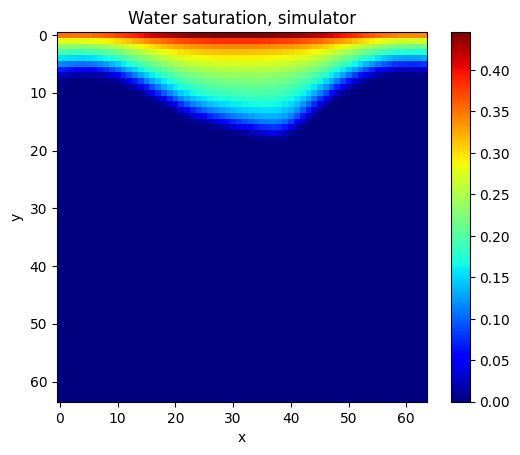

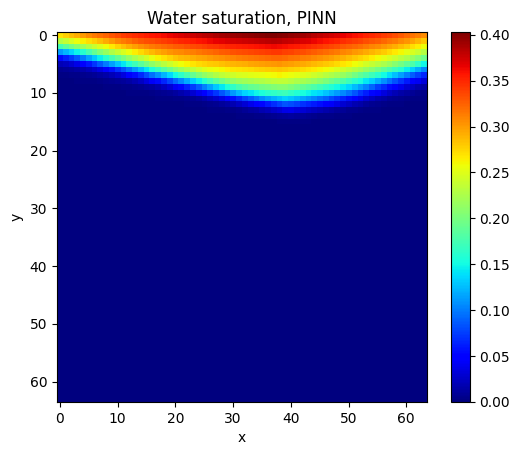

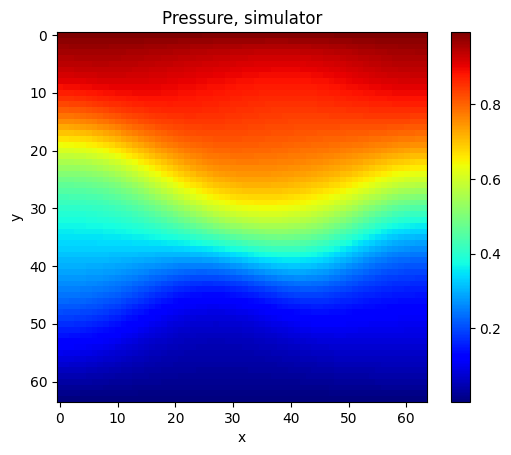

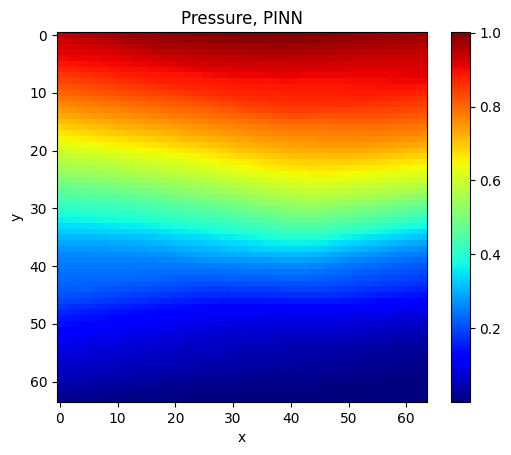

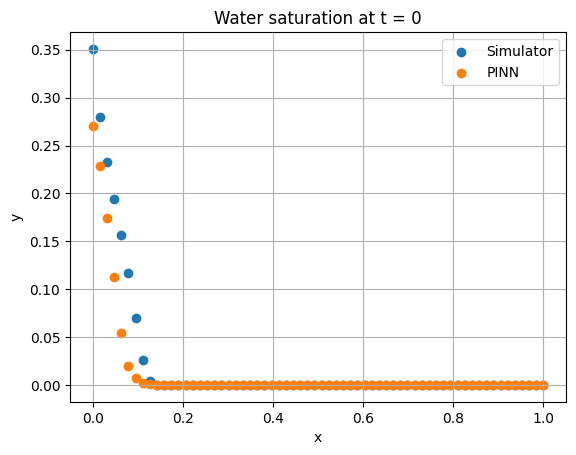

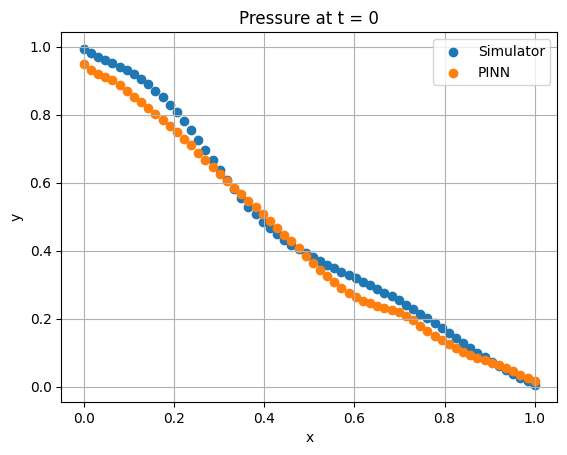

In [29]:
plt.figure()
plt.title('Water saturation, simulator')
plt.imshow(swat[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
plt.title('Water saturation, PINN')
plt.imshow(model_prediction[:, 2].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure()
plt.title('Pressure, simulator')
plt.imshow(pres[:, :, :, -1])
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()


plt.figure()
plt.title('Pressure, PINN')
plt.imshow(model_prediction[:, 0].reshape(nx0, nx1, nx2))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()    


plt.figure()
plt.title('Water saturation at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), swat[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 2].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


plt.figure()
plt.title('Pressure at t = 0')
plt.scatter(np.linspace(0.0, 1.0, nx0), pres[:, 0, 0, -1], label='Simulator')
plt.scatter(np.linspace(0.0, 1.0, nx0), model_prediction[:, 0].reshape(nx0, nx1, nx2)[:, 0, 0], label='PINN')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()